In [1]:
import pandas as pd
import numpy as np
import os

# Load and Merge Data
- want to see cycle data

In [2]:
fp = os.path.join('..', 'data_out', 'Symptoms_clean.csv')
symptoms =pd. read_csv(fp)
#set zeroes as nans
symptoms.replace(0, np.NaN, inplace=True)
symptoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13512 entries, 0 to 13511
Data columns (total 14 columns):
symptom_id    13512 non-null int64
user_id       13512 non-null int64
acne          4230 non-null float64
backache      5027 non-null float64
bloating      5278 non-null float64
cramp         6943 non-null float64
diarrhea      2233 non-null float64
dizzy         2170 non-null float64
headache      4402 non-null float64
mood          5177 non-null float64
nausea        2194 non-null float64
sore          4090 non-null float64
date          13512 non-null object
date_fix      13511 non-null object
dtypes: float64(10), int64(2), object(2)
memory usage: 1.4+ MB


#### Agg Symptoms

In [3]:
categories = ['acne', 'backache', 'bloating', 'cramp',
       'diarrhea', 'dizzy', 'headache', 'mood', 'nausea', 'sore']
agg_symptoms = symptoms[categories].agg(['mean', 'count']).T
agg_symptoms.sort_values('count', ascending=False)
agg_symptoms.reset_index().plot.bar(x='index', y='count', title='Top Reported Symptoms')

#### Agg to the User Level

In [4]:
users_agg_symptoms = symptoms.groupby(['user_id'], as_index=False)[categories].mean()
users_agg_symptoms.sample(5)

,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
3063,5541,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3658,6558,100.000000,46.0,15.000000,62.000000,11.0,13.0,28.0,17.0,12.0,10.0
2093,3891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,50.0,NaN
2092,3890,36.600000,46.6,36.666667,49.333333,9.0,19.0,27.0,45.6,NaN,32.2
2342,4311,36.833333,NaN,NaN,59.333333,NaN,NaN,NaN,NaN,NaN,NaN


#### Cycle Data

In [5]:
fp = os.path.join('..', 'data_out', 'Clean_periods_clean.csv')
periods = pd.read_csv(fp, parse_dates=['start_date_fix', 'end_date_fix'])
periods.length = pd.to_timedelta(periods.length, unit='days')
periods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31964 entries, 0 to 31963
Data columns (total 7 columns):
period_id         31964 non-null int64
start_date        31964 non-null object
end_date          31964 non-null object
user_id           31964 non-null int64
start_date_fix    31964 non-null datetime64[ns]
end_date_fix      31964 non-null datetime64[ns]
length            31964 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(2), timedelta64[ns](1)
memory usage: 1.7+ MB


#### create cycle lengths
- drop any cycle with length over 45 days

In [6]:
print('predrop:', periods.shape[0])
periods_multi_respos = periods.groupby('user_id').filter(lambda x: x.shape[0] > 1).copy()
print('postdrop:', periods_multi_respos.shape[0])
#sort
periods_multi_respos.sort_values(['user_id', 'start_date_fix'], inplace=True)
#roll column
periods_multi_respos['previous_start_date'] = periods_multi_respos.start_date_fix.shift(1)
#calc difference
periods_multi_respos['cycle_length'] = periods_multi_respos['start_date_fix'] - periods_multi_respos['previous_start_date']
#set non repeated user it 
cumcount = periods_multi_respos.groupby('user_id').cumcount()
periods_multi_respos.loc[cumcount==0, 'cycle_length'] = np.NaN
#drop missing data
periods_multi_respos.dropna(subset=['cycle_length'], inplace=True)
#check cycle_length stats
print('stats pre drop:', periods_multi_respos.cycle_length.describe(), sep='\n')
#drop any cycle ove 45 days
periods_multi_respos = periods_multi_respos[periods_multi_respos.cycle_length < pd.to_timedelta(45, unit='days')]
print('stats post drop:', periods_multi_respos.cycle_length.describe(), sep='\n')
#create cycle df
select = ['user_id', 'previous_start_date', 'cycle_length']
cycles = periods_multi_respos[select].copy()
cycles.rename(columns={'previous_start_date': 'cycle_start_date'}, inplace=True)
fp = os.path.join('..', 'data_out', 'cycles.csv')
cycles.to_csv(fp, index=False)
cycles.sample(5)

predrop: 31964
postdrop: 28549
stats pre drop:
count                      25377
mean     36 days 18:27:59.347440
std      34 days 18:54:53.149531
min              0 days 00:00:00
25%             27 days 00:00:00
50%             29 days 00:00:00
75%             34 days 00:00:00
max            947 days 00:00:00
Name: cycle_length, dtype: object
stats post drop:
count                      21962
mean     28 days 18:00:25.571441
std       5 days 07:30:12.911247
min              0 days 00:00:00
25%             26 days 00:00:00
50%             28 days 00:00:00
75%             31 days 00:00:00
max             44 days 00:00:00
Name: cycle_length, dtype: object


,user_id,cycle_start_date,cycle_length
23860,1983,2018-02-05,31 days
21976,5773,2017-11-18,27 days
11273,1460,2016-09-02,28 days
18828,4651,2017-06-29,30 days
2044,1389,2015-06-03,21 days


# Get data to add to data set

In [7]:
fp = os.path.join('..', 'data_out', 'User_clean.csv')
users = pd.read_csv(fp)
users = users[['user_id', 'cycle_length_initial', 'period_length_initial']]
users.columns = ['user_id', 'expected_cycle_length', 'expected_period_length']
#expected dates as timedeltas
users.expected_cycle_length = pd.to_timedelta(users.expected_cycle_length, unit='days')
users.expected_period_length = pd.to_timedelta(users.expected_period_length, unit='days')
users.sample(5)

,user_id,expected_cycle_length,expected_period_length
5119,5446,30 days,7 days
1333,1660,28 days,5 days
3226,3553,28 days,4 days
4311,4638,35 days,7 days
214,536,25 days,4 days


#### get average period length

In [8]:
mean_period_days = pd.to_timedelta(periods.groupby('user_id').apply(lambda x: x.length.dt.days.mean()), unit='days').reset_index()
mean_period_days.columns = ['user_id', 'mean_period_length']
mean_period_days.sample(5)

,user_id,mean_period_length
200,527,5 days
6244,6707,4 days
2789,3178,6 days
4985,5423,3 days
2764,3153,6 days


#### get average cycle

In [9]:
mean_cycle_days = pd.to_timedelta(cycles.groupby('user_id')['cycle_length'].apply(lambda x: x.dt.days.mean()), unit='days').reset_index()
mean_cycle_days.columns = ['user_id', 'mean_cycle_length']
mean_cycle_days.sample(5)

,user_id,mean_cycle_length
1460,3677,40 days 00:00:00
2477,5981,21 days 00:00:00
2693,6422,32 days 15:25:42.857142
1759,4310,25 days 00:00:00
935,2478,31 days 09:36:00


#### format data for modeling
- data adds, symptoms, expected values

In [10]:
print('premerge:', cycles.shape)
model_sample = cycles.merge(users, on='user_id', how='left')
model_sample = model_sample.merge(mean_period_days, on='user_id', how='left')
model_sample = model_sample.merge(mean_cycle_days, on='user_id', how='left')
model_sample = model_sample.merge(users_agg_symptoms, on='user_id', how='left')
print('postmerge:', model_sample.shape)
fp = os.path.join('..', 'data_out', 'model_sampl.csv')
model_sample.to_csv(fp, index=False)
model_sample.sample(5)

premerge: (21962, 3)
postmerge: (21962, 17)


,user_id,cycle_start_date,cycle_length,expected_cycle_length,expected_period_length,mean_period_length,mean_cycle_length,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
17736,5194,2017-07-10,33 days,30 days,5 days,4 days 00:00:00,32 days 00:00:00,NaN,NaN,NaN,NaN,51.0,35.0,NaN,NaN,36.0,NaN
2796,1089,2016-05-01,28 days,28 days,6 days,4 days 16:00:00,27 days 15:04:11.162790,NaN,39.0,42.000000,70.5,NaN,NaN,NaN,NaN,NaN,NaN
4538,1537,2016-07-12,33 days,32 days,7 days,5 days 12:00:00,31 days 02:40:00,NaN,NaN,40.000000,55.0,NaN,NaN,47.000000,44.000000,40.0,NaN
12475,3688,2018-02-25,22 days,28 days,8 days,6 days 00:51:25.714285,23 days 18:40:00,29.0,67.5,55.166667,57.6,51.5,56.0,67.666667,63.333333,51.0,67.833333
18873,5619,2018-08-31,36 days,28 days,11 days,5 days 22:09:13.846153,26 days 07:12:00,NaN,NaN,62.000000,36.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Error
average estimated cycle length error is 3 days 11 hours

In [11]:
np.abs(model_sample.cycle_length - model_sample.expected_cycle_length).describe()

count                     21962
mean     3 days 11:45:38.439122
std      3 days 22:23:25.612809
min             0 days 00:00:00
25%             1 days 00:00:00
50%             2 days 00:00:00
75%             4 days 00:00:00
max            37 days 00:00:00
dtype: object

#### Look at good gap in data

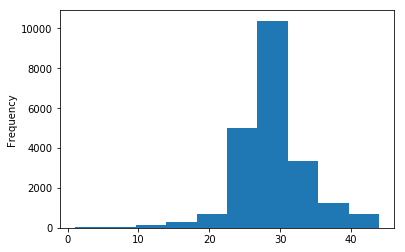

In [12]:
days = cycles.cycle_length.dt.days
days = days[(days > 0 ) & (days < 100)]
days.plot.hist()

# Review cycles data

In [13]:
cycles['cycle_length_days'] = cycles.cycle_length.dt.days
user_cycles = cycles.groupby('user_id')['cycle_length_days'].agg(['std', 'mean', 'count'])
user_cycles = user_cycles.dropna()
#print('mean std for cycle: {:,.4f}'.format(user_cycles['std'].mean()))
user_cycles.mean()

std       3.639562
mean     29.150913
count     9.790083
dtype: float64

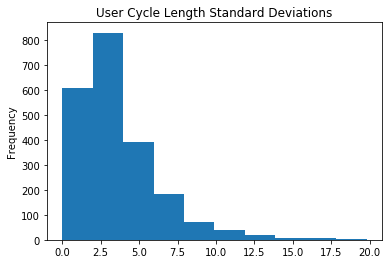

In [14]:
user_cycles['std'].plot.hist(title='User Cycle Length Standard Deviations')

#### add columns for modeling

In [15]:
model_sample['expected_cycle_length_days'] = model_sample['expected_cycle_length'].dt.days
model_sample['expected_period_length_days'] = model_sample['expected_period_length'].dt.days
model_sample['mean_period_length_days'] = model_sample['mean_period_length'].dt.days
model_sample['mean_cycle_length_days'] = model_sample['mean_cycle_length'].dt.days
model_sample['cycle_length_days'] = model_sample['cycle_length'].dt.days
just_symptoms = ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
       'headache', 'mood', 'nausea', 'sore']
for col in just_symptoms:
    model_sample[col + '_0'] = model_sample[col].fillna(0)
    def to_bool(score):
        if np.isnan(score):
            return 0
        return 1
    model_sample[col + '_bool'] = model_sample[col].apply(to_bool)

#### create a test and train data set
- numpy expects a array of shape (sample, features)

In [16]:
from sklearn.model_selection import train_test_split

features = ['expected_cycle_length_days', 'expected_period_length_days', 'mean_period_length_days', 'mean_cycle_length_days']

feature_data = model_sample[features].values
target_data = model_sample[['cycle_length_days']].values

x_train, x_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.1, random_state=42)

print('train shape: {}\ntest shape: {}'.format(x_train.shape, x_test.shape))

train shape: (19765, 4)
test shape: (2197, 4)


In [17]:
def build_test(df, feature_cols, target_col):
    feature_data = model_sample[feature_cols].values
    target_data = model_sample[[target_col]].values
    return train_test_split(feature_data, target_data, test_size=0.1, random_state=42)

def many_lr(df, features_list, target_col):
    for index, feature_cols in enumerate(features_list):
        print('Run {}'.format(index + 1))
        x_train, x_test, y_train, y_test = build_test(df, feature_cols=feature_cols, target_col=target_col)
        lin_model = linear_model.LinearRegression()
        lin_model.fit(x_train, y_train)
        lin_predictions = lin_model.predict(x_test)
        for feature, coef in zip(feature_cols, lin_model.coef_[0]):
            print('{1}: {0:,.4f} '.format(coef, feature))
        # The mean squared error
        print("Mean squared error: %.2f"
              % mean_squared_error(y_test, lin_predictions))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f\n' % r2_score(y_test, lin_predictions))

#### Try linear regression

In [18]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
#get model and train
lin_model = linear_model.LinearRegression()
lin_model.fit(x_train, y_train)
lin_predictions = lin_model.predict(x_test)

In [20]:
# The coefficients
for feature, coef in zip(features, lin_model.coef_[0]):
    print('{0:,.4f} {1}'.format(coef, feature))
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, lin_predictions))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, lin_predictions))

0.0079 expected_cycle_length_days
0.0029 expected_period_length_days
-0.0080 mean_period_length_days
0.9887 mean_cycle_length_days
Mean squared error: 15.60
Variance score: 0.45


In [21]:
just_symptoms = ['acne_bool', 'backache_bool', 'bloating_bool', 'cramp_bool', 'diarrhea_bool', 'dizzy_bool',
       'headache_bool', 'mood_bool', 'nausea_bool', 'sore_bool']

#### Build and run many times
- adding the symptoms has almost no effect on the results

In [22]:
features = ['expected_cycle_length_days', 'expected_period_length_days', 'mean_period_length_days', 'mean_cycle_length_days']
just_expected = ['expected_cycle_length_days', 'expected_period_length_days']
just_symptoms_0 = ['acne_0', 'backache_0', 'bloating_0', 'cramp_0', 'diarrhea_0', 'dizzy_0',
       'headache_0', 'mood_0', 'nausea_0', 'sore_0']
just_symptoms_bool = ['acne_bool', 'backache_bool', 'bloating_bool', 'cramp_bool', 'diarrhea_bool', 'dizzy_bool',
       'headache_bool', 'mood_bool', 'nausea_bool', 'sore_bool']
many = features + just_symptoms_bool
many_lr(model_sample, features_list=[features, just_expected, just_symptoms_0, just_symptoms_bool, many], target_col='cycle_length_days')

Run 1
expected_cycle_length_days: 0.0079 
expected_period_length_days: 0.0029 
mean_period_length_days: -0.0080 
mean_cycle_length_days: 0.9887 
Mean squared error: 15.60
Variance score: 0.45

Run 2
expected_cycle_length_days: 0.5495 
expected_period_length_days: 0.1073 
Mean squared error: 26.85
Variance score: 0.06

Run 3
acne_0: 0.0059 
backache_0: 0.0052 
bloating_0: -0.0070 
cramp_0: 0.0055 
diarrhea_0: 0.0032 
dizzy_0: 0.0045 
headache_0: -0.0056 
mood_0: -0.0048 
nausea_0: -0.0004 
sore_0: -0.0072 
Mean squared error: 28.48
Variance score: 0.00

Run 4
acne_bool: 0.4689 
backache_bool: 0.2229 
bloating_bool: -0.2869 
cramp_bool: 0.3714 
diarrhea_bool: 0.2805 
dizzy_bool: -0.0201 
headache_bool: -0.0577 
mood_bool: -0.0924 
nausea_bool: -0.1486 
sore_bool: -0.5823 
Mean squared error: 28.54
Variance score: 0.00

Run 5
expected_cycle_length_days: 0.0076 
expected_period_length_days: 0.0029 
mean_period_length_days: -0.0085 
mean_cycle_length_days: 0.9888 
acne_bool: -0.0211 
backac

#### Run model of just data with feature info

In [23]:
all_symptoms_sample = model_sample[model_sample[just_symptoms].sum(axis=1) == 0]
many_lr(all_symptoms_sample, features_list=[features, just_expected, just_symptoms_0, just_symptoms_bool, many], target_col='cycle_length_days')

Run 1
expected_cycle_length_days: 0.0079 
expected_period_length_days: 0.0029 
mean_period_length_days: -0.0080 
mean_cycle_length_days: 0.9887 
Mean squared error: 15.60
Variance score: 0.45

Run 2
expected_cycle_length_days: 0.5495 
expected_period_length_days: 0.1073 
Mean squared error: 26.85
Variance score: 0.06

Run 3
acne_0: 0.0059 
backache_0: 0.0052 
bloating_0: -0.0070 
cramp_0: 0.0055 
diarrhea_0: 0.0032 
dizzy_0: 0.0045 
headache_0: -0.0056 
mood_0: -0.0048 
nausea_0: -0.0004 
sore_0: -0.0072 
Mean squared error: 28.48
Variance score: 0.00

Run 4
acne_bool: 0.4689 
backache_bool: 0.2229 
bloating_bool: -0.2869 
cramp_bool: 0.3714 
diarrhea_bool: 0.2805 
dizzy_bool: -0.0201 
headache_bool: -0.0577 
mood_bool: -0.0924 
nausea_bool: -0.1486 
sore_bool: -0.5823 
Mean squared error: 28.54
Variance score: 0.00

Run 5
expected_cycle_length_days: 0.0076 
expected_period_length_days: 0.0029 
mean_period_length_days: -0.0085 
mean_cycle_length_days: 0.9888 
acne_bool: -0.0211 
backac

#### Try SVM
- im surprised these aren't as good

In [52]:
from sklearn import svm
x_train, x_test, y_train, y_test = build_test(model_sample, features, 'cycle_length_days')
svm_model = svm.SVC(kernel='linear')
svm_model.fit(x_train, np.ravel(y_train))
svm_results = svm_model.predict(x_test)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.tolist(), svm_results.tolist()))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % r2_score(y_test.tolist(), svm_results.tolist()))

Mean squared error: 20.52
Variance score: 0.2816


In [53]:
x_train, x_test, y_train, y_test = build_test(model_sample, features, 'cycle_length_days')
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(x_train, np.ravel(y_train))
svm_results = svm_model.predict(x_test)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.tolist(), svm_results.tolist()))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % r2_score(y_test.tolist(), svm_results.tolist()))

C:\Users\ulrichw\AppData\Local\Continuum\anaconda2\envs\conda3env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean squared error: 21.03
Variance score: 0.2638


In [48]:
from scipy import stats
stats.describe(svm_results[:, np.newaxis] - y_test)

DescribeResult(nobs=2197, minmax=(array([-40], dtype=int64), array([27], dtype=int64)), mean=array([-0.36640874]), variance=array([20.901658]), skewness=array([-0.48477887]), kurtosis=array([15.62307713]))

# Do naive test
- mean suared error has significant improvement
- r2_score is just 0... as expected

In [79]:
mean_cycle = model_sample.cycle_length_days.mean()
naive_error = mean_squared_error(y_true=model_sample['cycle_length_days'].to_list(), 
                   y_pred=np.full(shape=(model_sample.shape[0],), fill_value=mean_cycle).tolist())
r_val = r2_score(y_true=model_sample['cycle_length_days'].to_list(), 
                   y_pred=np.full(shape=(model_sample.shape[0],), fill_value=mean_cycle).tolist())
print('Naive Error: {}\nr2_score: {}'.format(naive_error, r_val))

Naive Error: 28.22295888699675
r2_score: 0.0


In [81]:
(naive_error - 15.60) / naive_error

0.44725852230938706